In [197]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax.models import LotVolModel
import projplot as pjp
import pfjax.experimental.particle_filter as pfex

# module containing pfjax (for now)
sns.set_style("darkgrid")
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.0001
sigma_l = 0.0001
tau_h = 0.25
tau_l = 0.25

theta = jnp.log(jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l]))
theta_true = theta
dt = 0.1
n_res = 2
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)


In [118]:
n_res = 4
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_4, x_state_4 = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [119]:
n_res = 8
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_8, x_state_8 = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [120]:
n_res = 16
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_16, x_state_16 = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

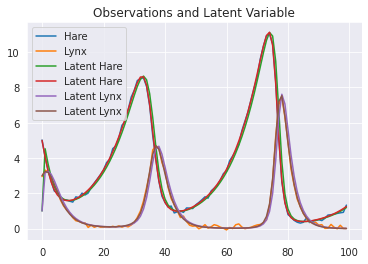

In [25]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0], label = "Hare")
plt.plot(y_meas[:, 1], label = "Lynx")
plt.plot(jnp.exp(x_state[:, :, 0]), label="Latent Hare")
plt.plot(jnp.exp(x_state[:, :, 1]), label="Latent Lynx")
plt.title("Observations and Latent Variable")
plt.legend()

In [7]:
x_state.shape

(100, 2, 2)

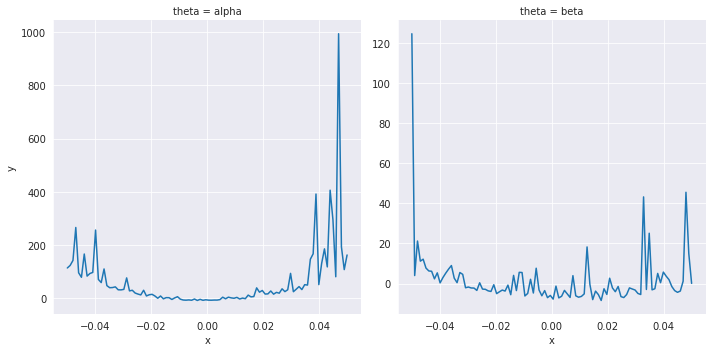

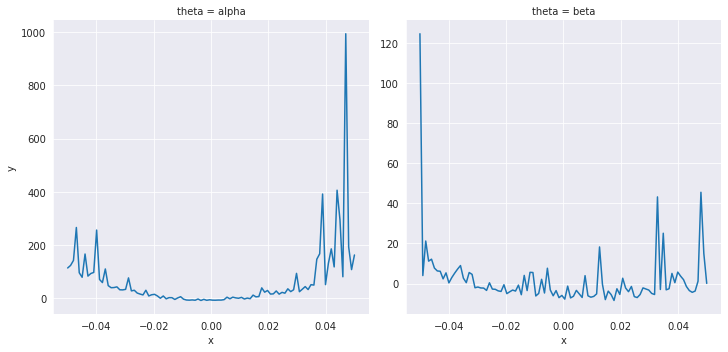

In [248]:
import pfjax.experimental.particle_filter as pfex
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)


theta_lims = np.array([[-0.05, 0.05] , [-0.05, 0.05], np.log([3.8, 4.2]), np.log([0.8, 1.2]), 
                       np.log([0.00001, 0.0002]), np.log([0.00001, 0.0002]), np.log([0.08, 0.12]), np.log([0.08, 0.12])])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000

theta_ind = jnp.array([0, 1])
theta_lims = theta_lims[np.array(theta_ind)]
theta_names = np.array(theta_names)[np.array(theta_ind)]
@jax.jit
def lotvol_pflik(theta_sub):
    theta_temp = theta_true * jnp.array([1.0])
    theta_temp = theta_temp.at[theta_ind].set(theta_sub)
    temp = pf.particle_filter(theta=theta_temp, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    temp = pf.particle_loglik(temp["logw"])
    return -temp

theta_plots = np.array(theta)[np.array(theta_ind)]
plot_df = proj_data(lotvol_pflik,
                    theta_plots, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

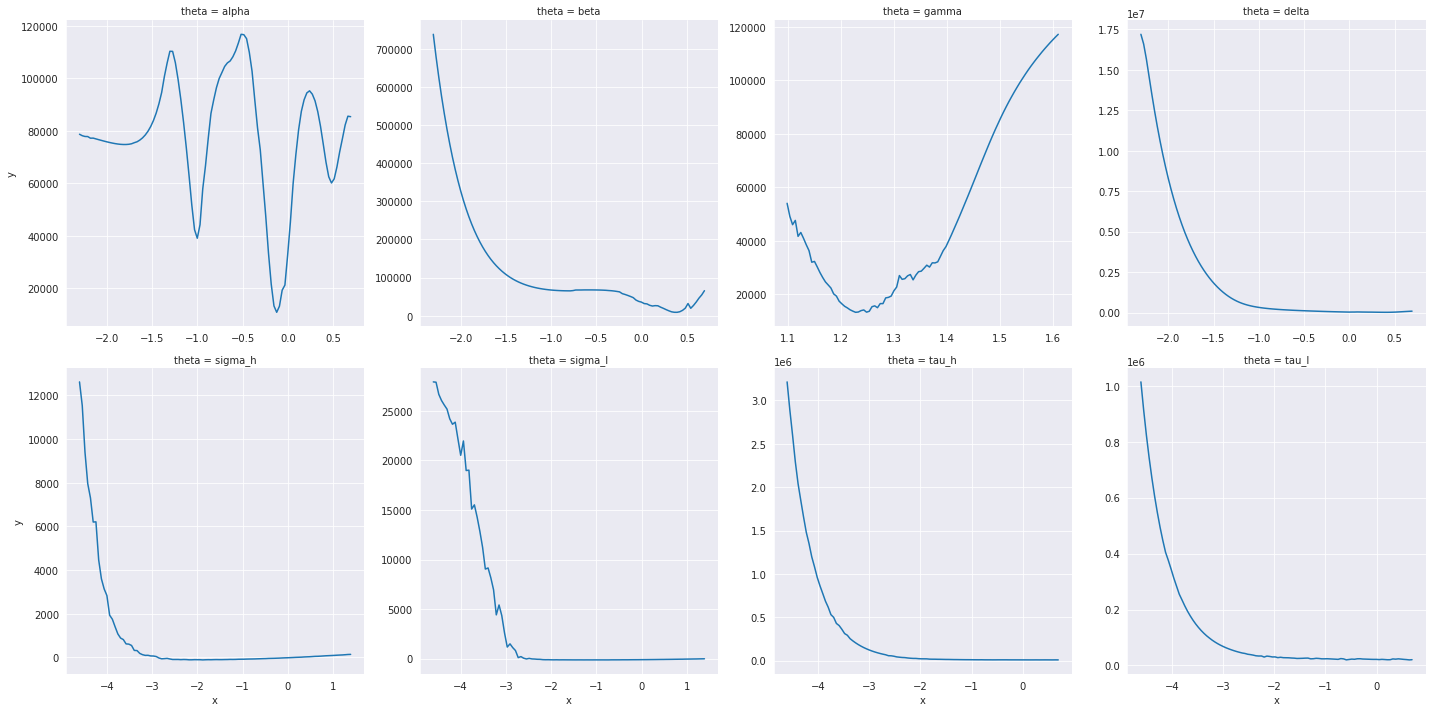

In [42]:
sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)


In [156]:
import optax
from functools import partial
def update_params_acc(params, subkey, opt_state, n_particles=100,
                      y_meas=None, mask=None, optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    out = pfex.auxillary_filter_linear(
        model=lotvol_model,
        key=subkey,
        y_meas=y_meas,
        theta=params,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    score = out["score"]
    hess = out["fisher"]
    updates, opt_state = optimizer.update(-1.0 * score, opt_state)
    return optax.apply_updates(params, updates), hess


def stoch_opt_acc(params, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Args:
        params: A jnp.array that represents the initial values of the parameters.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    optimizer = optax.yogi(learning_rate)
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params_acc, n_particles=n_particles, y_meas=y_meas,
                                    mask=mask, optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    all_hessians = []
    for subkey in keys:
        params, hess = update_fn(params, subkey, opt_state)
        # all_hessians.append(hess)
    # all_hessians = jnp.array(all_hessians)
    # hess = jnp.mean(all_hessians, axis=0)
    return params, hess

In [255]:
params_unc, hess = stoch_opt_acc(jnp.array([0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), y_meas, key=key, learning_rate=0.1, iterations=100, n_particles=1000,
         mask=np.array([1,1,1,1,1,1,1,1]))

/root/workspace/pfjax/new_env/lib/python3.8/site-packages/jax/interpreters/mlir.py:512: UserWarning: Some donated buffers were not usable: ShapedArray(float32[8]).
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


In [122]:
params_unc_4, hess_4 = stoch_opt_acc(jnp.log(jnp.array([1.,1., 4., 1., 0.0001, 0.0001, 0.25, 0.25])), y_meas_4, key=key, learning_rate=0.00001, iterations=10, n_particles=100,
         mask=np.array([1,1,1,1,1,1,1,1]))

In [123]:
params_unc_8, hess_8 = stoch_opt_acc(jnp.log(jnp.array([1.,1., 4., 1., 0.0001, 0.0001, 0.25, 0.25])), y_meas_8, key=key, learning_rate=0.00001, iterations=10, n_particles=1000,
         mask=np.array([1,1,1,1,1,1,1,1]))

In [171]:
key, subkey = random.split(key)
params_unc_16, hess_16 = stoch_opt_acc(jnp.log(jnp.array([1.,1., 4., 1., 0.0001, 0.0001, 0.25, 0.25])), y_meas_16, key=subkey, learning_rate=0.00001, iterations=20, n_particles=1000,
         mask=np.array([1,1,1,1,1,1,1,1]))

/root/workspace/pfjax/new_env/lib/python3.8/site-packages/jax/interpreters/mlir.py:512: UserWarning: Some donated buffers were not usable: ShapedArray(float32[8]).
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


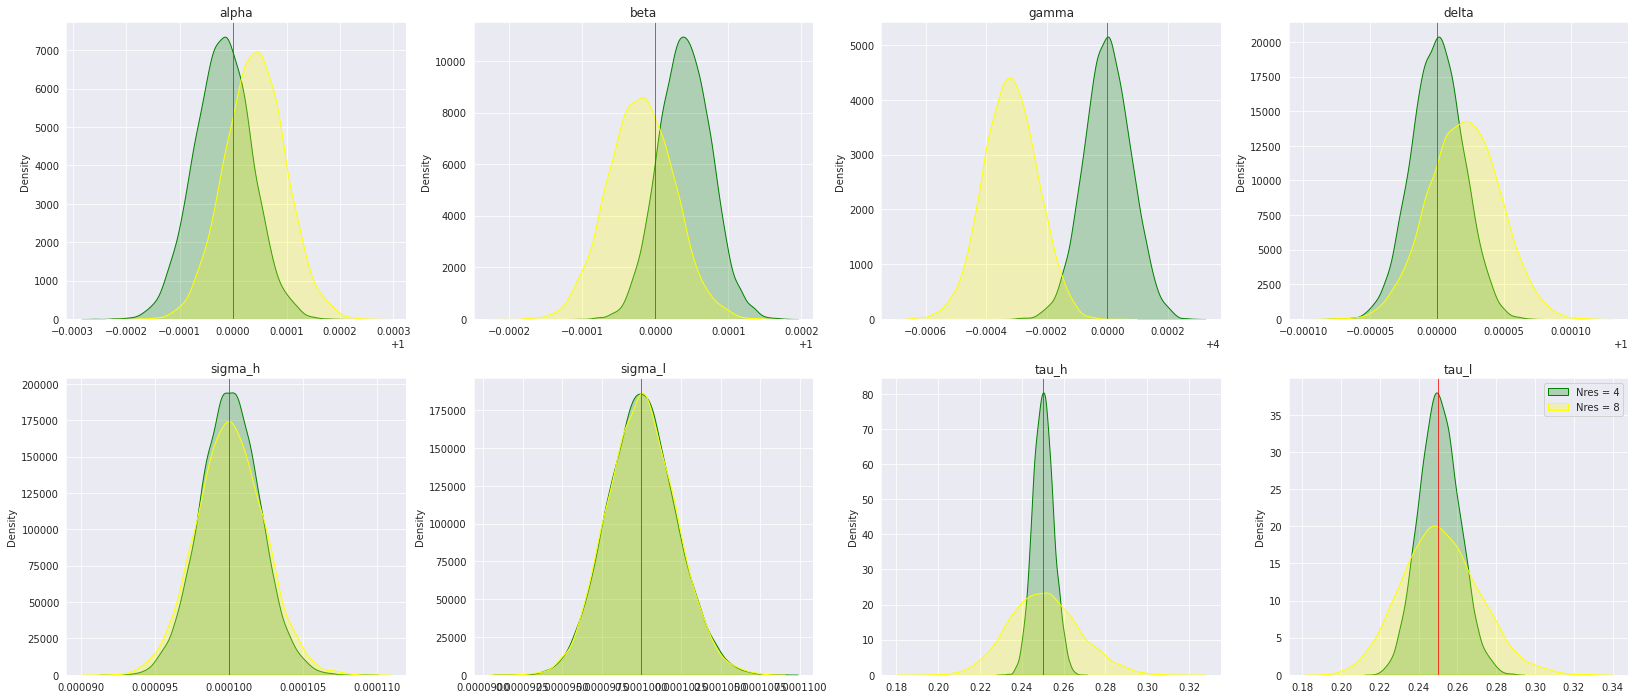

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_true = [1.0, 1.0, 4.0, 1.0, 0.0001, 0.0001, 0.25, 0.25]
var_hat = jnp.linalg.inv(-hess)
var_hat_4 = jnp.linalg.inv(-hess_4)
var_hat_8 = jnp.linalg.inv(-hess_8)
var_hat_16 = jnp.linalg.inv(-hess_16)
mle_samples = np.array(random.multivariate_normal(key=key, mean=params_unc, cov=var_hat, shape=(10_000, )))
mle_samples = np.exp(mle_samples)
mle_samples_4 = np.array(random.multivariate_normal(key=key, mean=params_unc_4, cov=var_hat_4, shape=(10_000, )))
mle_samples_4 = np.exp(mle_samples_4)
mle_samples_8 = np.array(random.multivariate_normal(key=key, mean=params_unc_8, cov=var_hat_8, shape=(10_000, )))
mle_samples_8 = np.exp(mle_samples_8)
mle_samples_16 = np.array(random.multivariate_normal(key=key, mean=params_unc_16, cov=var_hat_16, shape=(10_000, )))
mle_samples_16 = np.exp(mle_samples_16)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(28, 12))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True, color="Blue", label="Nres = 2").set_title(theta_names[ind])
    sns.kdeplot(mle_samples_4[:, ind], ax = _ax, shade = True, color="green", label="Nres = 4")
    sns.kdeplot(mle_samples_8[:, ind], ax = _ax, shade = True, color="yellow", label="Nres = 8")
    sns.kdeplot(mle_samples_16[:, ind], ax = _ax, shade = True, color="black", label="Nres = 16")
    plt.legend()
    _ax.axvline(theta_true[ind], color='red', lw = 0.75)

plt.show()


In [164]:
params_unc_16

DeviceArray([ 9.9999859e-05,  9.9999772e-05,  1.3859943e+00,
              9.9999292e-05, -9.2104397e+00, -9.2106390e+00,
             -1.3877946e+00, -1.3877946e+00], dtype=float32)

In [257]:
data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

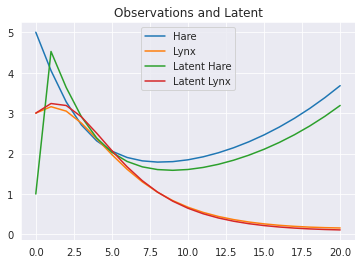

In [258]:
plt.plot(y_meas[:, 0], label="Hare")
plt.plot(y_meas[:, 1], label="Lynx")
plt.plot(jnp.exp(x_state[:21, 0, 0]), label="Latent Hare")
plt.plot(jnp.exp(x_state[:21, 1, 1]), label="Latent Lynx")
plt.title("Observations and Latent")
plt.legend()

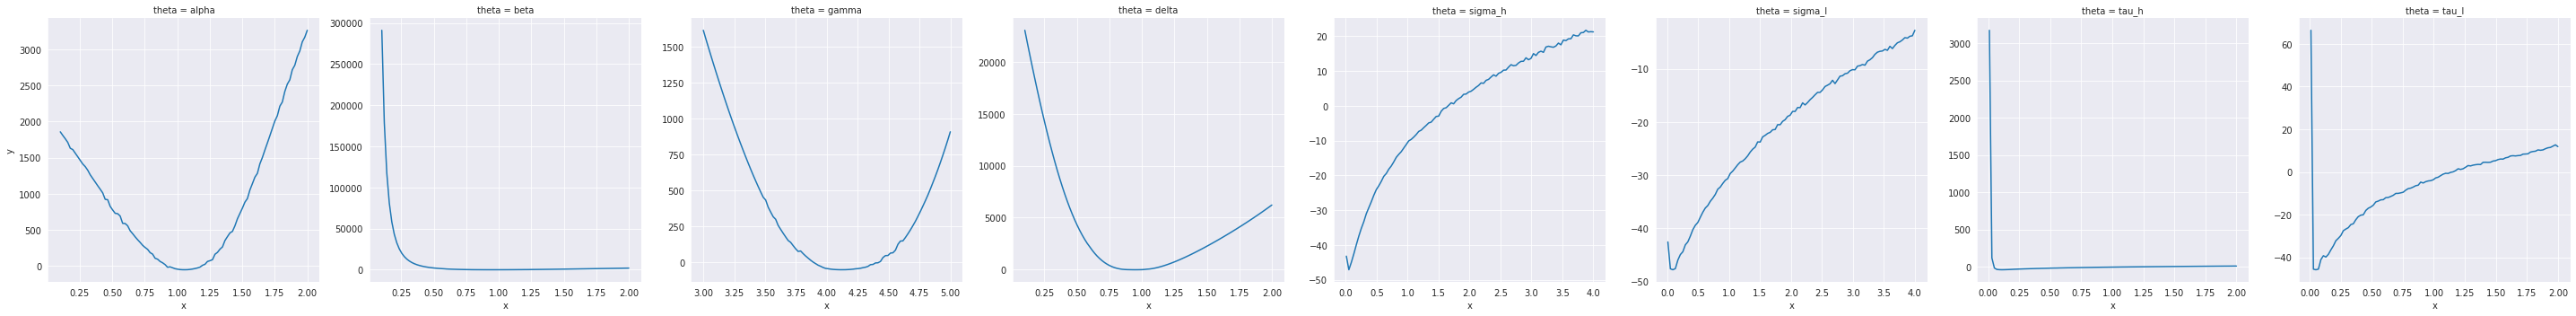

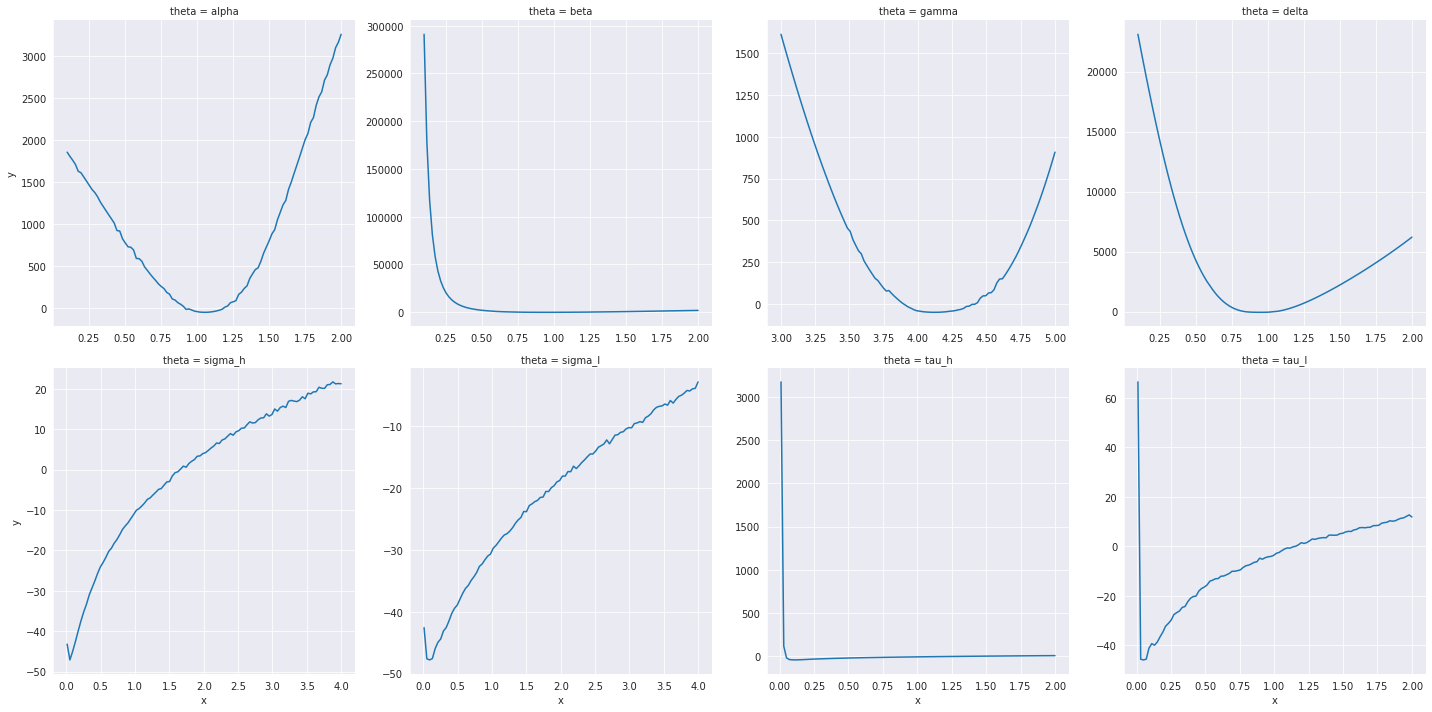

In [80]:
@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return -pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

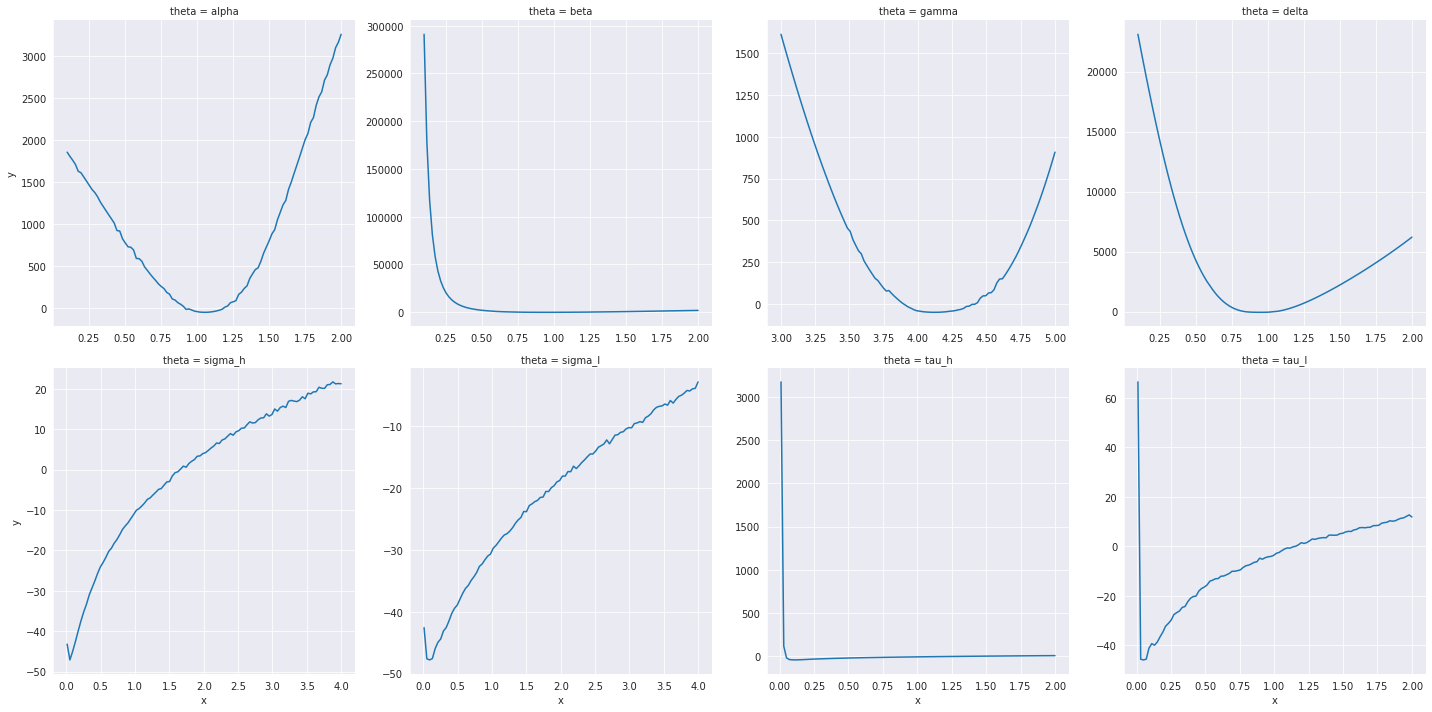

In [82]:
sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [263]:
params_unc, hess = stoch_opt_acc(jnp.log(jnp.array([1.0,1.0, 4.0, 1.0, 0.0001, 0.0001, 0.25, 0.25])), y_meas, key=key, learning_rate=0.00001, iterations=100, n_particles=1000,
         mask=np.array([1,1,1,1,1,1,1,1]))
params_unc

/root/workspace/pfjax/new_env/lib/python3.8/site-packages/jax/interpreters/mlir.py:512: UserWarning: Some donated buffers were not usable: ShapedArray(float32[8]).
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


DeviceArray([ 2.1999706e-04, -1.9999871e-04,  1.3863745e+00,
             -1.7999878e-04, -9.2103481e+00, -9.2104197e+00,
             -1.3872957e+00, -1.3872957e+00], dtype=float32)

In [264]:
jnp.exp(params_unc)

DeviceArray([1.0002201e+00, 9.9980003e-01, 4.0003204e+00, 9.9981999e-01,
             9.9999226e-05, 9.9992074e-05, 2.4974978e-01, 2.4974978e-01],            dtype=float32)

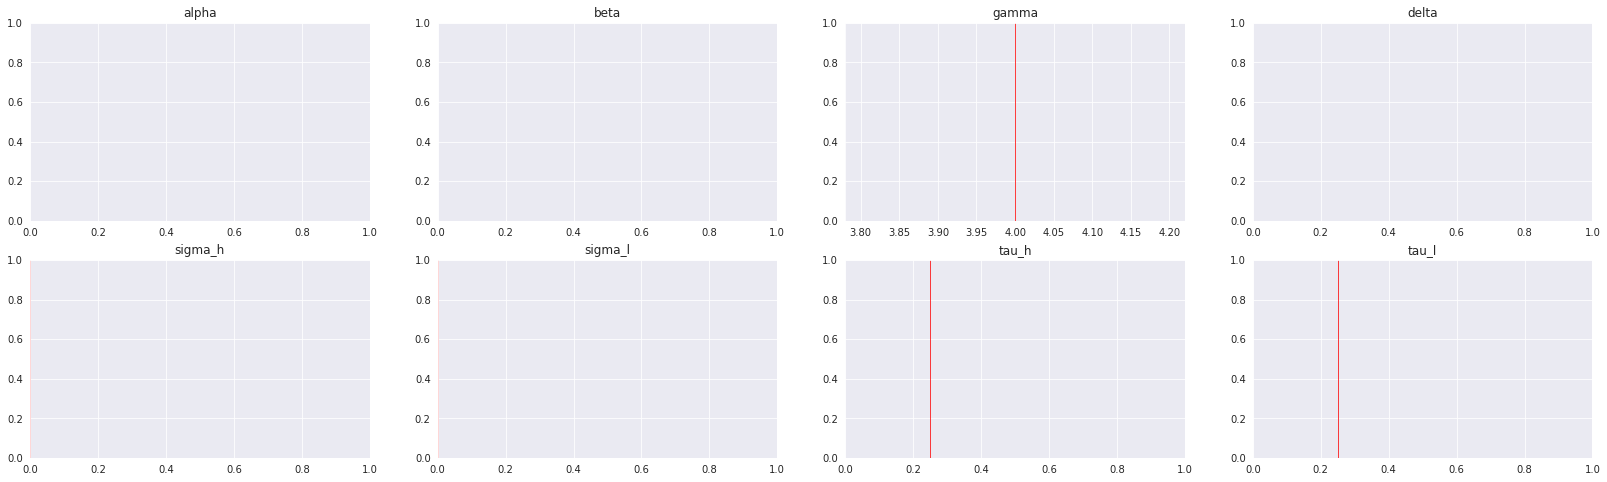

In [283]:
var_hat = jnp.linalg.inv(-hess)
newvar = np.array(var_hat)
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
newvar[np.diag_indices_from(newvar)] += 3e-2
mle_samples = np.array(random.multivariate_normal(key=key, mean=params_unc, cov=newvar, shape=(10_000, )))
mle_samples = np.exp(mle_samples)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(28, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(np.exp(theta_true[ind]), color='red', lw = 0.75)


In [280]:
mle_samples.shape

(10000, 8)